Here DMD on MJO is performed. Along with OLR (outgoing longwave radition) which is major proxy for MJO
Zonal wind U at 850 hpa and 200 hpa pressure levels are considered to include the nonlinearty.
Since more than one variable is considered and also there is no standard spatial reperesentation of
the MJO other OLR is considered.

Here we are first one to create a spatial representation of the MJO with OLR, U850 and U200
along with the standard DMD

In [1]:
import xarray as xr
import numpy as np
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt

Selected lat shapes: (9,) (9,) (9,)
Shapes after flattening:
OLR: (1461, 1296)
U850: (1461, 1296)
U200: (1461, 1296)
Combined X shape: (3888, 1461)
Optimal DMD rank: 245
X_dmd shape: (3888, 1461)


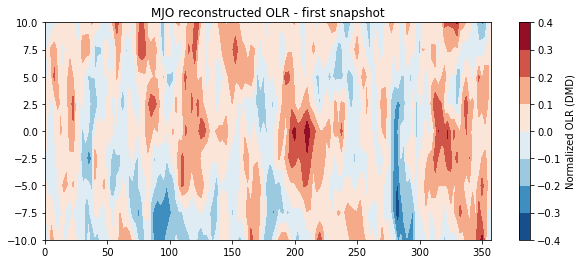

In [2]:

# Load datasets

olr = xr.open_dataset("olr.nc")['olr']
u850 = xr.open_dataset("u850.nc")['u']
u200 = xr.open_dataset("u200.nc")['u']

# Fix time dimension if necessary
for ds_name, ds in zip(['olr','u850','u200'], [olr,u850,u200]):
    if 'valid_time' in ds.dims:
        ds = ds.rename({'valid_time':'time'})
        if ds_name == 'olr': olr = ds
        if ds_name == 'u850': u850 = ds
        if ds_name == 'u200': u200 = ds


# 2. Select equatorial band (-10 to 10 deg)

lat_min, lat_max = -10, 10

def select_equator(ds, lat_min=-10, lat_max=10):
    # Works for ascending or descending latitude
    lat_sorted = np.all(np.diff(ds.lat.values) > 0)
    if lat_sorted:  # ascending
        return ds.sel(lat=slice(lat_min, lat_max))
    else:           # descending
        return ds.sel(lat=slice(lat_max, lat_min))

olr = select_equator(olr, lat_min, lat_max)
u850 = select_equator(u850, lat_min, lat_max)
u200 = select_equator(u200, lat_min, lat_max)

print("Selected lat shapes:", olr.lat.shape, u850.lat.shape, u200.lat.shape)


#  Select single pressure level for U-winds

if 'pressure_level' in u850.dims:
    u850 = u850.sel(pressure_level=850).squeeze()
if 'pressure_level' in u200.dims:
    u200 = u200.sel(pressure_level=200).squeeze()

#  Normalize along time

def normalize(ds):
    return (ds - ds.mean(dim='time')) / ds.std(dim='time')

olr = normalize(olr)
u850 = normalize(u850)
u200 = normalize(u200)


# Bandpass filter OLR (30-90 days)

def bandpass_filter(data, low_period=30, high_period=90, fs=1, order=4):
    nyq = 0.5 * fs
    low = 1.0 / high_period / nyq
    high = 1.0 / low_period / nyq
    b, a = butter(order, [low, high], btype='band')

    def _filter_1d(x):
        return filtfilt(b, a, x, axis=0)

    filtered = xr.apply_ufunc(
        _filter_1d, data,
        input_core_dims=[['time']],
        output_core_dims=[['time']],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[data.dtype]
    )
    return filtered

olr_filt = bandpass_filter(olr, 30, 90)


# Flatten lat-lon into feature vectors

def flatten_space(ds):
    if 'lat' in ds.dims and 'lon' in ds.dims:
        return ds.stack(features=('lat','lon')).transpose('time','features').values
    else:
        raise ValueError(f"Dataset has dimensions {ds.dims} — cannot flatten")

olr_flat = flatten_space(olr_filt)
u850_flat = flatten_space(u850)
u200_flat = flatten_space(u200)

print("Shapes after flattening:")
print("OLR:", olr_flat.shape)
print("U850:", u850_flat.shape)
print("U200:", u200_flat.shape)


#  Combine all variables for DMD

X = np.hstack([olr_flat, u850_flat, u200_flat]).T  # shape: features x time
X = np.nan_to_num(X)
print("Combined X shape:", X.shape)


#  Build DMD matrices

X1 = X[:, :-1]
X2 = X[:, 1:]

U, S, Vh = np.linalg.svd(X1, full_matrices=False)

# Choose optimal rank (99.99% energy)
energy = np.cumsum(S**2) / np.sum(S**2)
r_opt = np.searchsorted(energy, 0.95) + 1
print("Optimal DMD rank:", r_opt)

U_r = U[:, :r_opt]
S_r = np.diag(S[:r_opt])
V_r = Vh[:r_opt, :]

# Reduced DMD matrix
A_tilde = U_r.T @ X2 @ V_r.T @ np.linalg.inv(S_r)
eigvals, W = np.linalg.eig(A_tilde)
Phi = X2 @ V_r.T @ np.linalg.inv(S_r) @ W

# Reconstruct full DMD signal

b = np.linalg.lstsq(Phi, X[:,0], rcond=None)[0]
X_dmd = np.zeros_like(X)

for t in range(X.shape[1]):
    Lambda_t = np.diag(eigvals**t)
    X_dmd[:,t] = np.real(Phi @ (Lambda_t @ b))

print("X_dmd shape:", X_dmd.shape)


#  visualize first snapshot of reconstructed OLR
# 
olr_dmd_snapshot = X_dmd[:olr_flat.shape[1], 0].reshape(len(olr.lat), len(olr.lon))

plt.figure(figsize=(10,4))
plt.contourf(olr.lon, olr.lat, olr_dmd_snapshot, cmap='RdBu_r')
plt.colorbar(label='Normalized OLR (DMD)')
plt.title('MJO reconstructed OLR - first snapshot')
plt.show()


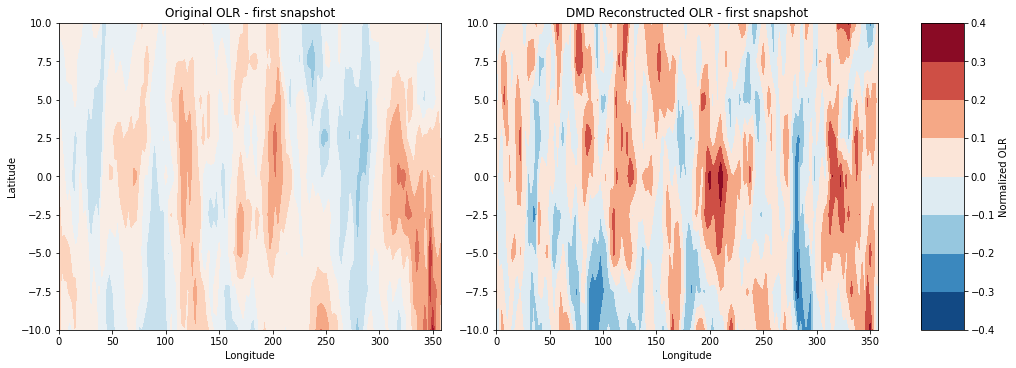

In [3]:
olr_orig_snapshot = olr_filt.isel(time=0).values
olr_dmd_snapshot = X_dmd[:olr_flat.shape[1], 0].reshape(len(olr.lat), len(olr.lon))

# Make symmetric color limits for positive/negative separation
lim = np.max(np.abs([
    olr_orig_snapshot.min(), olr_orig_snapshot.max(),
    olr_dmd_snapshot.min(), olr_dmd_snapshot.max()
]))

vmin = -lim
vmax =  lim

fig, axes = plt.subplots(1, 2, figsize=(14,5), constrained_layout=True)

# Original
cf1 = axes[0].contourf(olr.lon, olr.lat, olr_orig_snapshot,
                       cmap='RdBu_r', vmin=vmin, vmax=vmax)
axes[0].set_title('Original OLR - first snapshot')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')

# DMD reconstructed
cf2 = axes[1].contourf(olr.lon, olr.lat, olr_dmd_snapshot,
                       cmap='RdBu_r', vmin=vmin, vmax=vmax)
axes[1].set_title('DMD Reconstructed OLR - first snapshot')
axes[1].set_xlabel('Longitude')

# Common colorbar
cbar = fig.colorbar(cf2, ax=axes, orientation='vertical',
                    fraction=0.046, pad=0.04)
cbar.set_label('Normalized OLR')
plt.savefig("Figure12.jpg", format="jpg", dpi=300)
plt.show()
